[![Open in Dev Containers](https://img.shields.io/static/v1?label=Dev%20Containers&message=Open&color=blue&logo=visualstudiocode)](https://vscode.dev/redirect?url=vscode://ms-vscode-remote.remote-containers/cloneInVolume?url=https://github.com/radix-ai/conformal-tights) [![Open in GitHub Codespaces](https://img.shields.io/static/v1?label=GitHub%20Codespaces&message=Open&color=blue&logo=github)](https://github.com/codespaces/new/radix-ai/conformal-tights)

# 👖 Conformal Tights

Conformal Tights is a Python package that exports:

- a [scikit-learn](https://github.com/scikit-learn/scikit-learn) [meta-estimator](https://scikit-learn.org/stable/glossary.html#term-meta-estimator) that adds [conformal prediction](https://en.wikipedia.org/wiki/Conformal_prediction) of coherent [quantiles](https://en.wikipedia.org/wiki/Quantile) and [intervals](https://en.wikipedia.org/wiki/Prediction_interval) to any [scikit-learn regressor](https://scikit-learn.org/stable/glossary.html#term-regressor)
- a [Darts](https://github.com/unit8co/darts) [forecaster](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) that adds conformally calibrated [probabilistic time series forecasting](https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts) to any scikit-learn regressor

## Features

1. 🍬 *Sklearn meta-estimator*: add conformal prediction of quantiles and intervals to any scikit-learn regressor
2. 🔮 *Darts forecaster:* add conformally calibrated probabilistic forecasting to any scikit-learn regressor
3. 🌡️ *Conformally calibrated:* accurate quantiles, and intervals with reliable [coverage](https://en.wikipedia.org/wiki/Coverage_probability)
4. 🚦 *Coherent quantiles:* quantiles increase monotonically instead of [crossing](https://github.com/dmlc/xgboost/issues/9848) [each other](https://github.com/microsoft/LightGBM/issues/3447)
5. 👖 *Tight quantiles:* selects the lowest [dispersion](https://en.wikipedia.org/wiki/Statistical_dispersion) that provides the desired coverage
6. 🎁 *Data efficient:* requires only a small number of calibration examples to fit
7. 🐼 *Pandas support:* optionally predict on DataFrames and receive DataFrame output

## Using

### Quick links

1. [Installing](#installing)
2. [Predicting quantiles](#predicting-quantiles)
3. [Predicting intervals](#predicting-intervals)
4. [Forecasting time series](#forecasting-time-series)

### Installing

```sh
pip install conformal-tights
```

### Predicting quantiles

Conformal Tights exports a meta-estimator called `ConformalCoherentQuantileRegressor` that you can use to equip any scikit-learn regressor with a `predict_quantiles` method that predicts conformally calibrated quantiles. Example usage:

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import Markdown

In [2]:
from conformal_tights import ConformalCoherentQuantileRegressor
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Fetch dataset and split in train and test
X, y = fetch_openml("ames_housing", version=1, return_X_y=True, as_frame=True, parser="auto")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Create a regressor, equip it with conformal prediction, and fit on the train set
my_regressor = XGBRegressor(objective="reg:absoluteerror")
conformal_predictor = ConformalCoherentQuantileRegressor(estimator=my_regressor)
conformal_predictor.fit(X_train, y_train)

# Predict with the underlying regressor
ŷ_test = conformal_predictor.predict(X_test)

# Predict quantiles with the conformal predictor
ŷ_test_quantiles = conformal_predictor.predict_quantiles(
    X_test, quantiles=(0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975)
)

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/opt/conformal-tights-env/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


When the input data is a pandas DataFrame, the output is also a pandas DataFrame. For example, printing the head of `ŷ_test_quantiles` yields:

In [3]:
ŷ_test_quantiles.index.name = "house_id"
Markdown(ŷ_test_quantiles.head().to_markdown(floatfmt=".1f"))

|   house_id |    0.025 |     0.05 |      0.1 |      0.5 |      0.9 |     0.95 |    0.975 |
|-----------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|       1357 | 114743.7 | 120917.9 | 131752.6 | 156708.2 | 175907.8 | 187996.1 | 205443.4 |
|       2367 |  67382.7 |  80191.7 |  86871.8 | 105807.1 | 118465.3 | 127581.2 | 142419.1 |
|       2822 | 119068.0 | 131864.8 | 138541.6 | 159447.7 | 179227.2 | 197337.0 | 214134.1 |
|       2126 |  93885.8 | 100040.7 | 111345.5 | 134292.7 | 150557.1 | 164595.8 | 182524.1 |
|       1544 |  68959.8 |  81648.8 |  88364.1 | 108298.3 | 122329.6 | 132421.1 | 147225.6 |

Let's visualize the predicted quantiles on the test set:

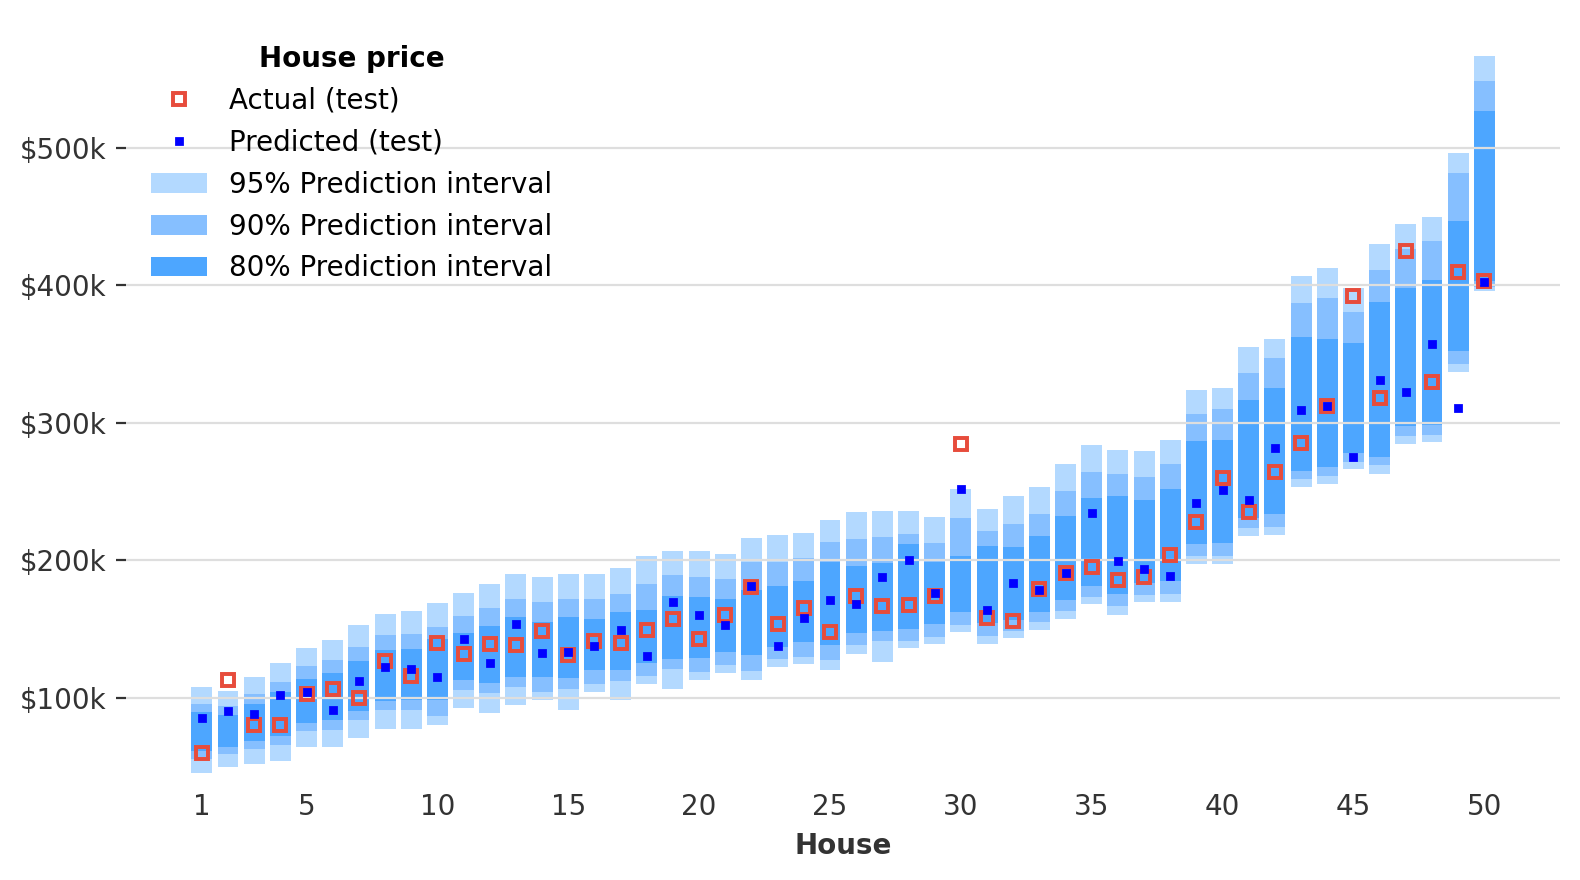

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = "retina"
plt.rc("font", family="DejaVu Sans", size=10)
plt.figure(figsize=(8, 4.5))
idx = ŷ_test_quantiles[0.5].sample(50, random_state=42).sort_values().index
x = list(range(1, len(idx) + 1))
x_ticks = [1, *list(range(5, len(idx) + 1, 5))]
for j in range(3):
    coverage = round(100 * (ŷ_test_quantiles.columns[-(j + 1)] - ŷ_test_quantiles.columns[j]))
    plt.bar(
        x,
        ŷ_test_quantiles.loc[idx].iloc[:, -(j + 1)] - ŷ_test_quantiles.loc[idx].iloc[:, j],
        bottom=ŷ_test_quantiles.loc[idx].iloc[:, j],
        color=["#b3d9ff", "#86bfff", "#4da6ff"][j],
        label=f"{coverage}% Prediction interval",
    )
plt.plot(
    x,
    y_test.loc[idx],
    "s",
    label="Actual (test)",
    markeredgecolor="#e74c3c",
    markeredgewidth=1.414,
    markerfacecolor="none",
    markersize=4,
)
plt.plot(x, ŷ_test.loc[idx], "s", color="blue", label="Predicted (test)", markersize=2)
plt.xlabel("House")
plt.xticks(x_ticks, x_ticks)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x/1000:,.0f}k"))
plt.gca().tick_params(axis="both", labelsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(False)
plt.grid(axis="y")
plt.legend(loc="upper left", title="House price", title_fontproperties={"weight": "bold"})
plt.tight_layout()

<details>
<summary>Expand to see the code that generated the graph above</summary>

```python
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = "retina"
plt.rc("font", family="DejaVu Sans", size=10)
plt.figure(figsize=(8, 4.5))
idx = ŷ_test_quantiles[0.5].sample(50, random_state=42).sort_values().index
x = list(range(1, len(idx) + 1))
x_ticks = [1, *list(range(5, len(idx) + 1, 5))]
for j in range(3):
    coverage = round(100 * (ŷ_test_quantiles.columns[-(j + 1)] - ŷ_test_quantiles.columns[j]))
    plt.bar(
        x,
        ŷ_test_quantiles.loc[idx].iloc[:, -(j + 1)] - ŷ_test_quantiles.loc[idx].iloc[:, j],
        bottom=ŷ_test_quantiles.loc[idx].iloc[:, j],
        color=["#b3d9ff", "#86bfff", "#4da6ff"][j],
        label=f"{coverage}% Prediction interval",
    )
plt.plot(
    x,
    y_test.loc[idx],
    "s",
    label="Actual (test)",
    markeredgecolor="#e74c3c",
    markeredgewidth=1.414,
    markerfacecolor="none",
    markersize=4,
)
plt.plot(x, ŷ_test.loc[idx], "s", color="blue", label="Predicted (test)", markersize=2)
plt.xlabel("House")
plt.xticks(x_ticks, x_ticks)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x/1000:,.0f}k"))
plt.gca().tick_params(axis="both", labelsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(False)
plt.grid(axis="y")
plt.legend(loc="upper left", title="House price", title_fontproperties={"weight": "bold"})
plt.tight_layout()
```
</details>

### Predicting intervals

In addition to quantile prediction, you can use `predict_interval` to predict conformally calibrated prediction intervals. Compared to quantiles, these focus on reliable coverage over quantile accuracy. Example usage:

In [5]:
# Predict an interval for each example with the conformal predictor
ŷ_test_interval = conformal_predictor.predict_interval(X_test, coverage=0.95)

# Measure the coverage of the prediction intervals on the test set
coverage = ((ŷ_test_interval.iloc[:, 0] <= y_test) & (y_test <= ŷ_test_interval.iloc[:, 1])).mean()
print(coverage)  # 96.6%

0.9659090909090909


When the input data is a pandas DataFrame, the output is also a pandas DataFrame. For example, printing the head of `ŷ_test_interval` yields:

In [6]:
ŷ_test_interval.index.name = "house_id"
ŷ_test_interval.columns = [0.025, 0.975]
Markdown(ŷ_test_interval.head().to_markdown(floatfmt=".1f"))

|   house_id |    0.025 |    0.975 |
|-----------:|---------:|---------:|
|       1357 | 107202.8 | 206290.4 |
|       2367 |  66665.1 | 146004.8 |
|       2822 | 115591.8 | 220314.8 |
|       2126 |  85288.1 | 183037.8 |
|       1544 |  67889.9 | 150646.2 |

### Forecasting time series

Conformal Tights also exports a Darts forecaster called `DartsForecaster` that uses a `ConformalCoherentQuantileRegressor` to make conformally calibrated probabilistic time series forecasts. To demonstrate its usage, let's begin by loading a time series dataset:

In [7]:
from darts.datasets import ElectricityConsumptionZurichDataset

# Load a forecasting dataset
ts = ElectricityConsumptionZurichDataset().load()
ts = ts.resample("h")

# Split the dataset into covariates X and target y
X = ts.drop_columns(["Value_NE5", "Value_NE7"])
y = ts["Value_NE5"]  # NE5 = Household energy consumption

# Add categorical covariates to X
X = X.add_holidays(country_code="CH")
X = X.add_datetime_attribute("month")
X = X.add_datetime_attribute("dayofweek")
X = X.add_datetime_attribute("hour")
X_categoricals = ["holidays", "month", "dayofweek", "hour"]

Printing the tail of the covariates time series `X.pd_dataframe()` yields:

In [8]:
import pandas as pd

X_df = X.pd_dataframe()
X_df["Timestamp"] = pd.to_datetime(X_df.index)
X_df["Timestamp"] = X_df["Timestamp"].dt.strftime("%Y‑%m‑%d %Hh")  # noqa: RUF001
X_df.set_index("Timestamp", inplace=True)
Markdown(X_df.tail().to_markdown(floatfmt=".1f"))

| Timestamp      |   Hr [%Hr] |   RainDur [min] |   StrGlo [W/m2] |   T [°C] |   WD [°] |   WVs [m/s] |   WVv [m/s] |   p [hPa] |   holidays |   month |   dayofweek |   hour |
|:---------------|-----------:|----------------:|----------------:|---------:|---------:|------------:|------------:|----------:|-----------:|--------:|------------:|-------:|
| 2022‑08‑30 20h |       70.2 |             0.0 |             0.0 |     19.9 |    290.2 |         1.7 |         1.5 |     968.5 |        0.0 |     7.0 |         1.0 |   20.0 |
| 2022‑08‑30 21h |       70.1 |             0.0 |             0.0 |     19.5 |    239.2 |         1.0 |         0.7 |     968.1 |        0.0 |     7.0 |         1.0 |   21.0 |
| 2022‑08‑30 22h |       71.3 |             0.0 |             0.0 |     19.5 |     28.9 |         1.5 |         1.3 |     967.9 |        0.0 |     7.0 |         1.0 |   22.0 |
| 2022‑08‑30 23h |       80.4 |             0.0 |             0.0 |     18.9 |     24.3 |         1.6 |         1.1 |     967.9 |        0.0 |     7.0 |         1.0 |   23.0 |
| 2022‑08‑31 00h |       81.6 |             1.0 |             0.0 |     18.7 |    293.5 |         0.9 |         0.3 |     967.8 |        0.0 |     7.0 |         2.0 |    0.0 |

We can now equip a scikit-learn regressor with conformal prediction using `ConformalCoherentQuantileRegressor` as before, and then equip that conformal predictor with probabilistic time series forecasting using `DartsForecaster`:

In [9]:
from conformal_tights import DartsForecaster, ConformalCoherentQuantileRegressor
from pandas import Timestamp
from xgboost import XGBRegressor

# Split the dataset into train and test
test_cutoff = Timestamp("2022-06-01")
y_train, y_test = y.split_after(test_cutoff)
X_train, X_test = X.split_after(test_cutoff)

# Now let's:
# 1. Create an sklearn regressor of our choosing, in this case `XGBRegressor`
# 2. Add conformal quantile prediction to the regressor with `ConformalCoherentQuantileRegressor`
# 3. Add probabilistic forecasting to the conformal predictor with `DartsForecaster`
my_regressor = XGBRegressor()
conformal_predictor = ConformalCoherentQuantileRegressor(estimator=my_regressor)
forecaster = DartsForecaster(
    model=conformal_predictor,
    lags=5 * 24,  # Add the last 5 days of the target to the prediction features
    lags_future_covariates=[0],  # Add the current timestamp's covariates to the prediction features
    categorical_future_covariates=X_categoricals,  # Convert these covariates to pd.Categorical
)

# Fit the forecaster
forecaster.fit(y_train, future_covariates=X_train)

# Make a probabilistic forecast 5 days into the future by predicting a set of conformally calibrated
# quantiles at each time step and drawing 500 samples from them
quantiles = (0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975)
forecast = forecaster.predict(
    n=5 * 24, future_covariates=X_test, num_samples=500, quantiles=quantiles
)

Printing the head of the forecast quantiles time series `forecast.quantiles_df(quantiles=quantiles)` yields:

In [10]:
forecast_quantiles_df = forecast.quantiles_df(quantiles=forecaster.quantiles)
forecast_quantiles_df["Timestamp"] = pd.to_datetime(forecast_quantiles_df.index)
forecast_quantiles_df["Timestamp"] = forecast_quantiles_df["Timestamp"].dt.strftime("%Y‑%m‑%d %Hh")  # noqa: RUF001
forecast_quantiles_df.set_index("Timestamp", inplace=True)
Markdown(forecast_quantiles_df.head().to_markdown(floatfmt=".1f"))

| Timestamp      |   Value_NE5_0.025 |   Value_NE5_0.05 |   Value_NE5_0.1 |   Value_NE5_0.25 |   Value_NE5_0.5 |   Value_NE5_0.75 |   Value_NE5_0.9 |   Value_NE5_0.95 |   Value_NE5_0.975 |
|:---------------|------------------:|-----------------:|----------------:|-----------------:|----------------:|-----------------:|----------------:|-----------------:|------------------:|
| 2022‑06‑01 01h |           19165.2 |          19268.3 |         19435.7 |          19663.0 |         19861.7 |          20062.2 |         20237.9 |          20337.7 |           20453.2 |
| 2022‑06‑01 02h |           19004.0 |          19099.0 |         19226.3 |          19453.7 |         19710.7 |          19966.1 |         20170.1 |          20272.8 |           20366.9 |
| 2022‑06‑01 03h |           19372.6 |          19493.0 |         19679.4 |          20027.6 |         20324.6 |          20546.3 |         20773.2 |          20910.3 |           21014.1 |
| 2022‑06‑01 04h |           21936.2 |          22105.6 |         22436.0 |          22917.5 |         23308.6 |          23604.8 |         23871.0 |          24121.7 |           24351.5 |
| 2022‑06‑01 05h |           25040.5 |          25330.5 |         25531.1 |          25910.4 |         26439.4 |          26903.2 |         27287.4 |          27493.9 |           27633.9 |

Let's visualize the forecast and its prediction interval on the test set:

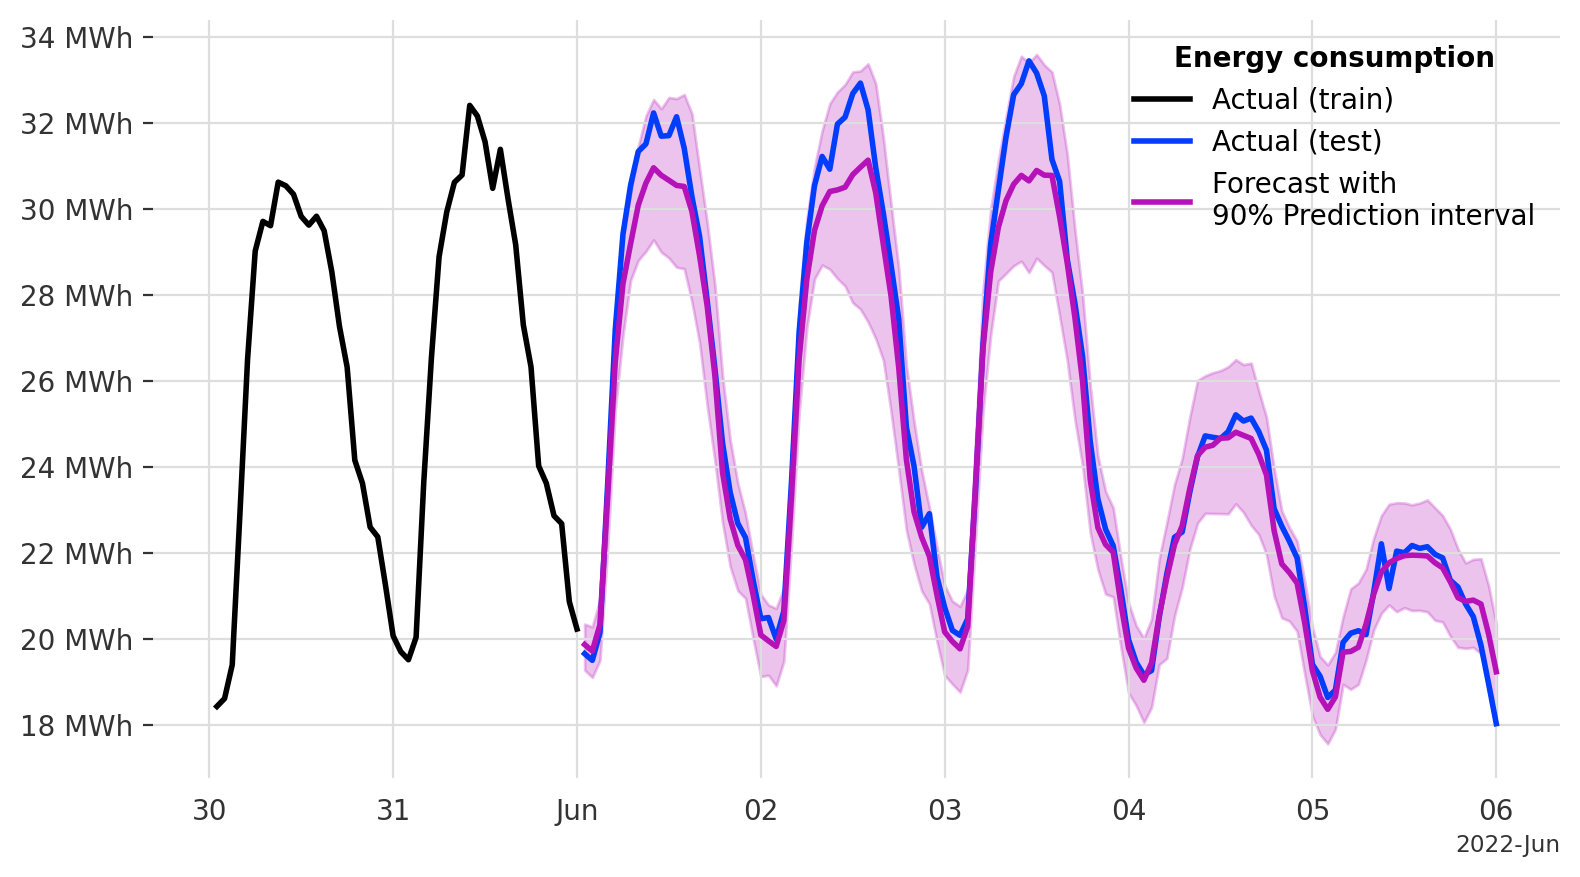

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = "retina"
plt.rc("font", family="DejaVu Sans", size=10)
plt.figure(figsize=(8, 4.5))
y_train[-2 * 24 :].plot(label="Actual (train)")
y_test[: len(forecast)].plot(label="Actual (test)")
forecast.plot(label="Forecast with\n90% Prediction interval", low_quantile=0.05, high_quantile=0.95)
plt.gca().set_xlabel("")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:,.0f} MWh"))
plt.gca().tick_params(axis="both", labelsize=10)
plt.legend(loc="upper right", title="Energy consumption", title_fontproperties={"weight": "bold"})
plt.tight_layout()

<details>
<summary>Expand to see the code that generated the graph above</summary>

```python
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = "retina"
plt.rc("font", family="DejaVu Sans", size=10)
plt.figure(figsize=(8, 4.5))
y_train[-2 * 24 :].plot(label="Actual (train)")
y_test[: len(forecast)].plot(label="Actual (test)")
forecast.plot(label="Forecast with\n90% Prediction interval", low_quantile=0.05, high_quantile=0.95)
plt.gca().set_xlabel("")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:,.0f} MWh"))
plt.gca().tick_params(axis="both", labelsize=10)
plt.legend(loc="upper right", title="Energy consumption", title_fontproperties={"weight": "bold"})
plt.tight_layout()
```
</details>

## Contributing

<details>
<summary>Prerequisites</summary>

<details>
<summary>1. Set up Git to use SSH</summary>

1. [Generate an SSH key](https://docs.github.com/en/authentication/connecting-to-github-with-ssh/generating-a-new-ssh-key-and-adding-it-to-the-ssh-agent#generating-a-new-ssh-key) and [add the SSH key to your GitHub account](https://docs.github.com/en/authentication/connecting-to-github-with-ssh/adding-a-new-ssh-key-to-your-github-account).
1. Configure SSH to automatically load your SSH keys:

    ```sh
    cat << EOF >> ~/.ssh/config

    Host *
      AddKeysToAgent yes
      IgnoreUnknown UseKeychain
      UseKeychain yes
      ForwardAgent yes
    EOF
    ```

</details>

<details>
<summary>2. Install Docker</summary>

1. [Install Docker Desktop](https://www.docker.com/get-started).
    - *Linux only*:
        - Export your user's user id and group id so that [files created in the Dev Container are owned by your user](https://github.com/moby/moby/issues/3206):

            ```sh
            cat << EOF >> ~/.bashrc
            
            export UID=$(id --user)
            export GID=$(id --group)
            EOF
            ```

</details>

<details>
<summary>3. Install VS Code or PyCharm</summary>

1. [Install VS Code](https://code.visualstudio.com/) and [VS Code's Dev Containers extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-containers). Alternatively, install [PyCharm](https://www.jetbrains.com/pycharm/download/).
2. *Optional:* install a [Nerd Font](https://www.nerdfonts.com/font-downloads) such as [FiraCode Nerd Font](https://github.com/ryanoasis/nerd-fonts/tree/master/patched-fonts/FiraCode) and [configure VS Code](https://github.com/tonsky/FiraCode/wiki/VS-Code-Instructions) or [configure PyCharm](https://github.com/tonsky/FiraCode/wiki/Intellij-products-instructions) to use it.

</details>

</details>

<details open>
<summary>Development environments</summary>

The following development environments are supported:

1. ⭐️ *GitHub Codespaces*: click on *Code* and select *Create codespace* to start a Dev Container with [GitHub Codespaces](https://github.com/features/codespaces).
1. ⭐️ *Dev Container (with container volume)*: click on [Open in Dev Containers](https://vscode.dev/redirect?url=vscode://ms-vscode-remote.remote-containers/cloneInVolume?url=https://github.com/radix-ai/conformal-tights) to clone this repository in a container volume and create a Dev Container with VS Code.
1. *Dev Container*: clone this repository, open it with VS Code, and run <kbd>Ctrl/⌘</kbd> + <kbd>⇧</kbd> + <kbd>P</kbd> → *Dev Containers: Reopen in Container*.
1. *PyCharm*: clone this repository, open it with PyCharm, and [configure Docker Compose as a remote interpreter](https://www.jetbrains.com/help/pycharm/using-docker-compose-as-a-remote-interpreter.html#docker-compose-remote) with the `dev` service.
1. *Terminal*: clone this repository, open it with your terminal, and run `docker compose up --detach dev` to start a Dev Container in the background, and then run `docker compose exec dev zsh` to open a shell prompt in the Dev Container.

</details>

<details>
<summary>Developing</summary>

- This project follows the [Conventional Commits](https://www.conventionalcommits.org/) standard to automate [Semantic Versioning](https://semver.org/) and [Keep A Changelog](https://keepachangelog.com/) with [Commitizen](https://github.com/commitizen-tools/commitizen).
- Run `poe` from within the development environment to print a list of [Poe the Poet](https://github.com/nat-n/poethepoet) tasks available to run on this project.
- Run `poetry add {package}` from within the development environment to install a run time dependency and add it to `pyproject.toml` and `poetry.lock`. Add `--group test` or `--group dev` to install a CI or development dependency, respectively.
- Run `poetry update` from within the development environment to upgrade all dependencies to the latest versions allowed by `pyproject.toml`.
- Run `cz bump` to bump the package's version, update the `CHANGELOG.md`, and create a git tag.

</details>
